# U1R analysis

This analyzes the results of running experiments with Bellogin's U1R method.

## Setup

In [27]:
library(readr)
library(purrr)
library(dplyr)
library(ggplot2)
library(tidyr)

In [2]:
options(repr.plot.height=4.5,
        repr.matrix.max.rows=10,
        repr.matrix.max.cols=10)

In [3]:
### User Data

First, we need to read the user data from the underlying MovieLens data:

users.meta.ml = read_delim("data/ml-1m/users.dat", delim=":",
                   col_names=c("user", "gender", "age", "occupation", "zip"),
                   col_types="i_c_c_c_c") %>%
    mutate(gender=as.factor(gender),
           age=rename_ages(age),
           occupation=as.factor(occupation))
users.meta.ml

Do the same thing with Last.FM:

users.meta.360k = read_csv("build/lastfm-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)

users.meta.360ksource("plot-tools.R")

### Demographic Utilities

We need to be able to normalize ages.

In [4]:
ml_age_bins = c("1"="1-17", "18"="18-24", "25"="25-34", "35"="35-44", "45"="45-49", "50"="50-55", "56"="56+")
ml_age_lbs = c(1, 18, 25, 35, 45, 50, 56)

Function to bound numeric ages:

In [5]:
bound_ages = function(ages, bounds=ml_age_lbs) {
    ages[ages <= 0] = NA
    selectors = rowSums(outer(ages, ml_age_lbs, ">="))
    factor(ml_age_bins[selectors], levels=ml_age_bins, ordered=TRUE)
}

Function to rename MovieLens age lower bounds:

In [6]:
rename_ages = function(ages) {
    stopifnot(is.character(ages))
    factor(ml_age_bins[ages], levels=ml_age_bins, ordered=TRUE)
}

## Read Data

### User Data

First, we need to read the user data from the underlying MovieLens data:

In [7]:
users.meta.ml = read_delim("data/ml-1m/users.dat", delim=":",
                   col_names=c("user", "gender", "age", "occupation", "zip"),
                   col_types="i_c_c_c_c") %>%
    mutate(gender=as.factor(gender),
           age=rename_ages(age),
           occupation=as.factor(occupation))
users.meta.ml

user,gender,age,occupation,zip
1,F,1-17,10,48067
2,M,56+,16,70072
3,M,25-34,15,55117
4,M,45-49,7,02460
5,M,25-34,20,55455
⋮,⋮,⋮,⋮,⋮
6036,F,25-34,15,32603
6037,F,45-49,1,76006
6038,F,56+,1,14706
6039,F,45-49,0,01060


Do the same thing with Last.FM:

In [8]:
users.meta.360k = read_csv("build/lastfm-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)

users.meta.360k

Parsed with column specification:
cols(
  id = col_integer(),
  key = col_character(),
  gender = col_character(),
  age = col_integer()
)


user,gender,age
1,F,18-24
2,F,NA
3,NA,NA
4,M,18-24
5,M,25-34
⋮,⋮,⋮
359343,M,25-34
359344,M,25-34
359345,M,18-24
359346,M,18-24


In [9]:
users.meta = bind_rows(ML1M=users.meta.ml,
                       LFM360K=users.meta.360k,
                       .id="DataSet")
users.meta

DataSet,user,gender,age,occupation,zip
ML1M,1,F,1-17,10,48067
ML1M,2,M,56+,16,70072
ML1M,3,M,25-34,15,55117
ML1M,4,M,45-49,7,02460
ML1M,5,M,25-34,20,55455
⋮,⋮,⋮,⋮,⋮,⋮
LFM360K,359343,M,25-34,NA,NA
LFM360K,359344,M,25-34,NA,NA
LFM360K,359345,M,18-24,NA,NA
LFM360K,359346,M,18-24,NA,NA


## Read Results

Now we must read the recommender results. Since this is the U1R protocol, we need the underlying item files.

In [13]:
item.results.ml = read_csv("build/movielens-1R-items.csv") %>%
    rename(user=User) %>%
    mutate(DataSet="ML1M")
item.results.ml

Parsed with column specification:
cols(
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  TargetItem = col_integer(),
  nDCG = col_double(),
  Rank = col_integer(),
  RecipRank = col_double(),
  AvgPrec = col_double()
)


DataSet,Partition,Algorithm,user,TargetItem,nDCG,Rank,RecipRank,AvgPrec
ML1M,4,Pop-B,4021,1438,0.11043278,532,0.0018796992,0.0018796992
ML1M,5,Pop-B,4049,748,0.10920193,571,0.0017513135,0.0017513135
ML1M,3,Pop-B,4026,2046,0.11721431,370,0.0027027027,0.0027027027
ML1M,4,Pop-B,4021,3406,0.09648659,1318,0.0007587253,0.0007587253
ML1M,5,Pop-B,4049,1275,0.12715874,233,0.0042918455,0.0042918455
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M,1,UU-B,678,2761,0.13197089,191,0.0052356021,0.0052356021
ML1M,2,UU-B,4198,2163,0.14529302,118,0.0084745763,0.0084745763
ML1M,1,UU-B,678,2837,0.09035518,2146,0.0004659832,0.0004659832
ML1M,2,UU-B,4198,3181,0.09172313,1914,0.0005224660,0.0005224660


In [62]:
item.results.lfm360k = read_csv("build/lastfm-item-1R-item-results.csv") %>%
    rename(user=User) %>%
    mutate(DataSet="LFM360K")
item.results.lfm360k

Parsed with column specification:
cols(
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  TargetItem = col_integer(),
  Rank = col_integer(),
  RecipRank = col_double(),
  nDCG = col_double(),
  AvgPrec = col_double()
)


DataSet,Partition,Algorithm,user,TargetItem,Rank,RecipRank,nDCG,AvgPrec
LFM360K,3,UU-C,242356,24464,NA,0,0,NA
LFM360K,3,UU-B,242356,24464,NA,0,0,NA
LFM360K,3,UU-B,242356,25251,NA,0,0,NA
LFM360K,3,UU-C,242356,25251,NA,0,0,NA
LFM360K,5,UU-B,237592,14895,NA,0,0,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K,1,MF-B,94964,110980,97663,1.023929e-05,0.06032992,1.023929e-05
LFM360K,1,MF-B,94964,53104,26733,3.740695e-05,0.06799791,3.740695e-05
LFM360K,1,MF-B,94964,61576,29964,3.337338e-05,0.06724523,3.337338e-05
LFM360K,1,MF-B,94964,27426,21482,4.655060e-05,0.06948864,4.655060e-05


In [63]:
item.results = bind_rows(item.results.ml, item.results.lfm360k)

In [64]:
overall.results = item.results %>%
    select(DataSet, Algorithm, RecipRank, nDCG) %>%
    group_by(DataSet, Algorithm) %>%
    summarize(nDCG=mean(nDCG), MRR=mean(RecipRank)) %>%
    ungroup()
overall.results

DataSet,Algorithm,nDCG,MRR
LFM360K,II-B,0.11521055,1.457182e-02
LFM360K,II-C,0.06933316,4.356273e-04
LFM360K,II-CS,0.11512288,1.498513e-02
LFM360K,MF-B,0.07099392,2.400604e-04
LFM360K,MF-C,0.06302425,6.661219e-05
⋮,⋮,⋮,⋮
ML1M,MF-B,0.1005116,0.003013896
ML1M,MF-E,0.1000357,0.003083938
ML1M,Pop-B,0.1051980,0.006273357
ML1M,UU-B,0.1309468,0.019808926


In [84]:
best.algos = overall.results %>%
    group_by(DataSet) %>%
    summarize(Best.nDCG=max(nDCG),
              BestAlgo = Algorithm[which.max(nDCG)])
best.algos

DataSet,Best.nDCG,BestAlgo
LFM360K,0.1152106,II-B
ML1M,0.1309468,UU-B


## User Prevalence

Since we selected test data by items, users can appear more than once. Let's see how often users appear as test users:

In [65]:
user.stats = item.results %>%
    group_by(DataSet, user) %>%
    summarize(TestItemCount=n())
summary(user.stats$TestItemCount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.00   27.00   54.00   67.77   90.00 1504.00 

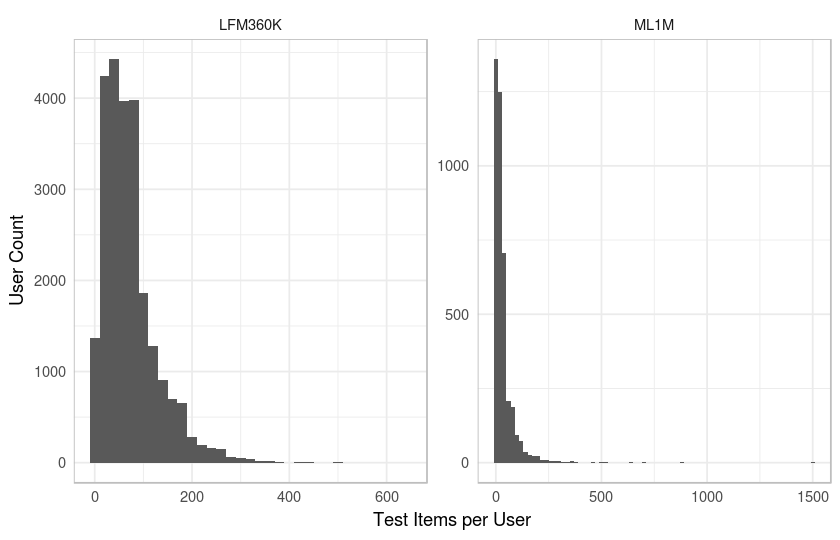

In [68]:
make.plot("u1r-user-item-dist", width=5.5, height=2, {
    ggplot(user.stats) +
        aes(x=TestItemCount) +
        geom_histogram(binwidth=20) +
        facet_wrap(~ DataSet, scales="free") +
        theme_paper() +
        xlab("Test Items per User") +
        ylab("User Count")
})

How often do we get test pairs for each gender?

In [69]:
gender.stats = user.stats %>%
    inner_join(users.meta) %>%
    group_by(DataSet, gender) %>%
    summarize(TestUsers=n(), TestPairs=sum(TestItemCount)) %>%
    group_by(DataSet) %>%
    mutate(UserFrac=TestUsers / sum(TestUsers),
           PairFrac=TestPairs / sum(TestPairs))
gender.stats

Joining, by = c("DataSet", "user")


DataSet,gender,TestUsers,TestPairs,UserFrac,PairFrac
LFM360K,F,5785,372762,0.23713876,0.2088117
LFM360K,M,16300,1231569,0.66816971,0.6898932
LFM360K,NA,2310,180828,0.09469154,0.1012952
ML1M,F,1089,36264,0.27008929,0.2564204
ML1M,M,2943,105160,0.72991071,0.7435796


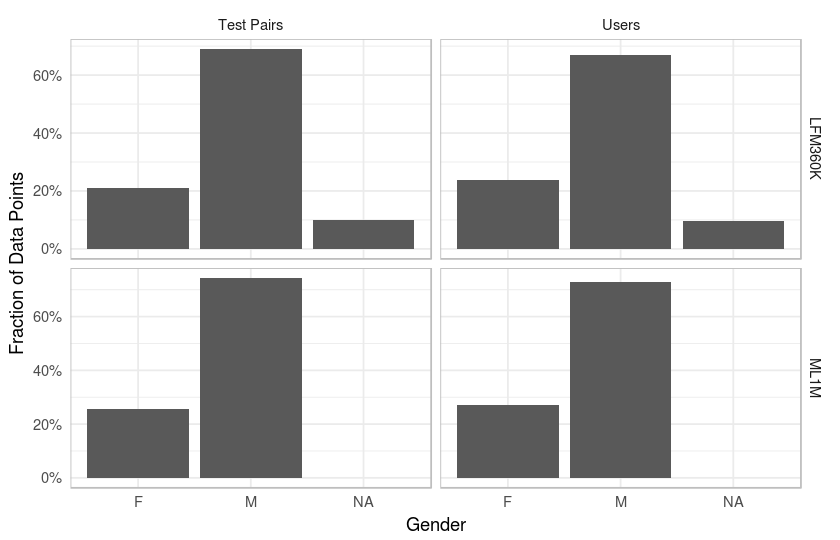

In [70]:
make.plot("u1r-test-data-dist", width=5.5, height=2, {
ggplot(gender.stats %>%
           gather("var", "val", UserFrac, PairFrac) %>%
           mutate(var=recode(var, UserFrac="Users", PairFrac="Test Pairs"))) +
    aes(x=gender, y=val) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ var, scales="free") +
    scale_y_continuous(labels=scales::percent) +
    theme_paper() +
    ylab("Fraction of Data Points") +
    xlab("Gender")
})

We can see that these are distributed similarly to the underlying user distribution. This is good.

## Gender-Based Accuracy Results

In [71]:
gender.results.raw = item.results %>%
    inner_join(users.meta) %>%
    select(DataSet, Algorithm, gender, user, RecipRank, nDCG)
gender.results.pu = gender.results.raw %>%
    group_by(DataSet, Algorithm, user) %>%
    summarize(N=n(), U.nDCG=mean(nDCG), U.MRR=mean(RecipRank))
summary(gender.results.pu$N)
gender.results = gender.results.raw %>%
    inner_join(gender.results.pu) %>%
    group_by(DataSet, Algorithm, gender) %>%
    summarize(nDCG=mean(nDCG), MRR=mean(RecipRank),
              U.nDCG=mean(U.nDCG), U.MRR=mean(U.MRR)) %>%
    ungroup()
gender.results

Joining, by = c("DataSet", "user")


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   6.000   7.651  10.000 188.000 

Joining, by = c("DataSet", "Algorithm", "user")


DataSet,Algorithm,gender,nDCG,MRR,U.nDCG,U.MRR
LFM360K,II-B,F,0.11598505,0.0149162039,0.11598505,0.0149162039
LFM360K,II-B,M,0.11540313,0.0145693681,0.11540313,0.0145693681
LFM360K,II-B,NA,0.11230240,0.0138785750,0.11230240,0.0138785750
LFM360K,II-C,F,0.06973698,0.0003512151,0.06973698,0.0003512151
LFM360K,II-C,M,0.06934831,0.0004648344,0.06934831,0.0004648344
⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M,Pop-B,M,0.1063249,0.007020403,0.1063249,0.007020403
ML1M,UU-B,F,0.1264665,0.016491610,0.1264665,0.016491610
ML1M,UU-B,M,0.1324918,0.020952889,0.1324918,0.020952889
ML1M,UU-E,F,0.1020110,0.002070063,0.1020110,0.002070063


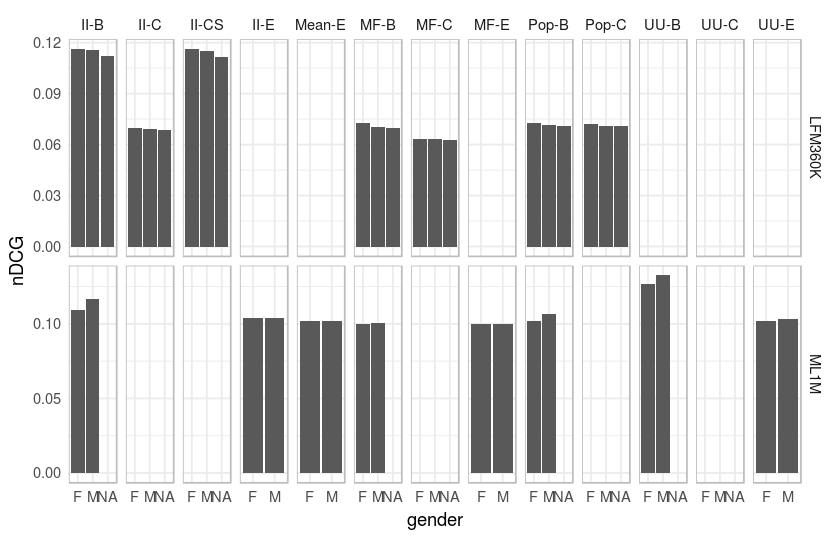

In [72]:
gender.ndcg.ml = gender.results %>%
    filter(DataSet == "ML1M") %>%
    select(Algorithm, gender, Overall=nDCG, PerUser=U.nDCG) %>%
    gather("Aggregation", "nDCG", Overall, PerUser)
make.plot("u1r-gender-ndcg-ml", width=5.5, height=2, {
    ggplot(gender.results) +
        aes(x=gender, y=nDCG) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        theme_paper()
})

Joining, by = "DataSet"


DataSet,Algorithm,gender,nDCG,MRR,U.nDCG,U.MRR,Best.nDCG,BestAlgo,Label
LFM360K,II-B,F,0.1159851,0.01491620,0.1159851,0.01491620,0.1152106,II-B,II-B on LFM360K
LFM360K,II-B,M,0.1154031,0.01456937,0.1154031,0.01456937,0.1152106,II-B,II-B on LFM360K
LFM360K,II-B,NA,0.1123024,0.01387857,0.1123024,0.01387857,0.1152106,II-B,II-B on LFM360K
ML1M,UU-B,F,0.1264665,0.01649161,0.1264665,0.01649161,0.1309468,UU-B,UU-B on ML1M
ML1M,UU-B,M,0.1324918,0.02095289,0.1324918,0.02095289,0.1309468,UU-B,UU-B on ML1M


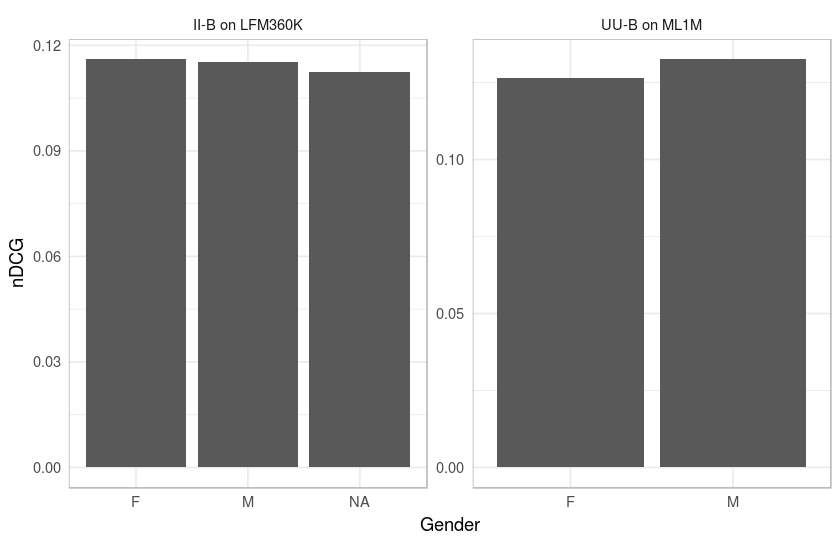

In [91]:
trimmed.gender.results = gender.results %>% 
    inner_join(best.algos) %>% 
    filter(Algorithm == BestAlgo) %>%
    mutate(Label=sprintf("%s on %s", Algorithm, DataSet))
make.plot("u1r-gender-ndcg-minimal", width=5.5, height=2, {
    ggplot(trimmed.gender.results) +
        aes(x=gender, y=nDCG) +
        geom_bar(stat="identity") +
        facet_wrap(~ Label, scales="free") +
        theme_paper() +
        xlab("Gender")
})

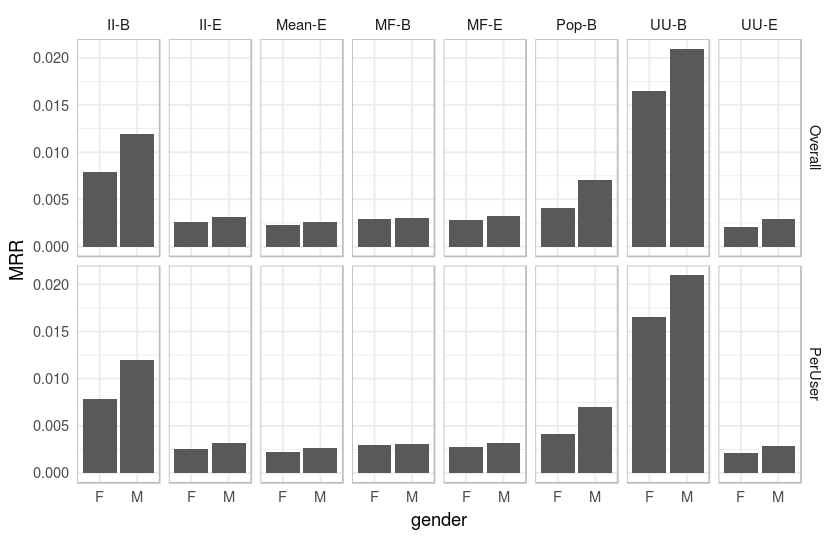

In [73]:
gender.mrr.ml = gender.results %>%
    filter(DataSet == "ML1M") %>%
    select(Algorithm, gender, Overall=MRR, PerUser=U.MRR) %>%
    gather("Aggregation", "MRR", Overall, PerUser)
ggplot(gender.mrr.ml) +
    aes(x=gender, y=MRR) +
    geom_bar(stat="identity") +
    facet_grid(Aggregation ~ Algorithm, scales="free") +
    theme_paper()

## Age-based Accuracy Results

In [75]:
age.results.raw = item.results %>%
    inner_join(users.meta) %>%
    select(DataSet, Algorithm, age, user, RecipRank, nDCG)
age.results.pu = age.results.raw %>%
    group_by(DataSet, Algorithm, user) %>%
    summarize(N=n(), U.nDCG=mean(nDCG), U.MRR=mean(RecipRank))
summary(age.results.pu$N)
age.results = age.results.raw %>%
    inner_join(age.results.pu) %>%
    group_by(DataSet, Algorithm, age) %>%
    summarize(nDCG=mean(nDCG), MRR=mean(RecipRank),
              U.nDCG=mean(U.nDCG), U.MRR=mean(U.MRR)) %>%
    ungroup()
age.results

Joining, by = c("DataSet", "user")


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   6.000   7.651  10.000 188.000 

Joining, by = c("DataSet", "Algorithm", "user")


DataSet,Algorithm,age,nDCG,MRR,U.nDCG,U.MRR
LFM360K,II-B,1-17,0.1207145,0.01728173,0.1207145,0.01728173
LFM360K,II-B,18-24,0.1158593,0.01372971,0.1158593,0.01372971
LFM360K,II-B,25-34,0.1126686,0.01381344,0.1126686,0.01381344
LFM360K,II-B,35-44,0.1153457,0.01621331,0.1153457,0.01621331
LFM360K,II-B,45-49,0.1222298,0.01988506,0.1222298,0.01988506
⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M,UU-E,25-34,0.1025093,0.002726368,0.1025093,0.002726368
ML1M,UU-E,35-44,0.1045525,0.002881013,0.1045525,0.002881013
ML1M,UU-E,45-49,0.1051021,0.002700964,0.1051021,0.002700964
ML1M,UU-E,50-55,0.1056337,0.002644780,0.1056337,0.002644780


Joining, by = "DataSet"


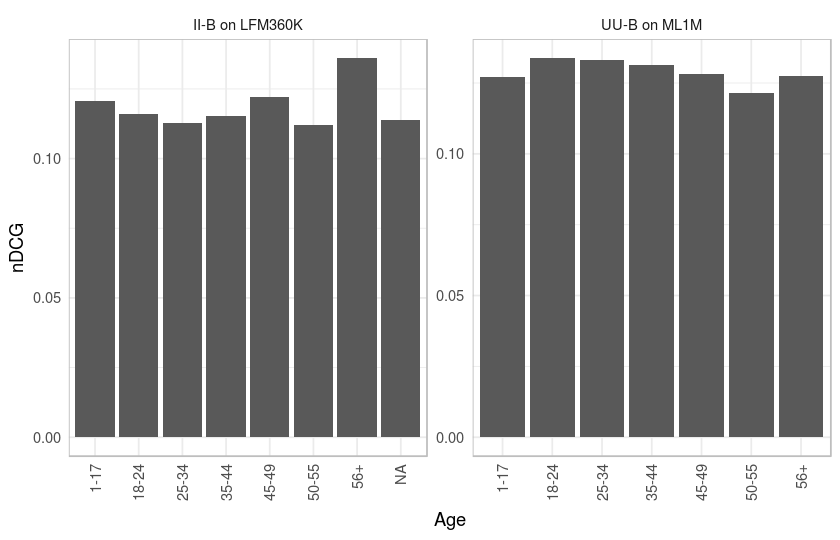

In [88]:
trimmed.age.results = age.results %>% 
    inner_join(best.algos) %>% 
    filter(Algorithm == BestAlgo) %>%
    mutate(Label=sprintf("%s on %s", Algorithm, DataSet))
make.plot("u1r-age-ndcg-minimal", width=5.5, height=2, {
    ggplot(trimmed.age.results) +
        aes(x=age, y=nDCG) +
        geom_bar(stat="identity") +
        facet_wrap(~ Label, scales="free") +
        theme_paper() +
        theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) +
        xlab("Age")
})

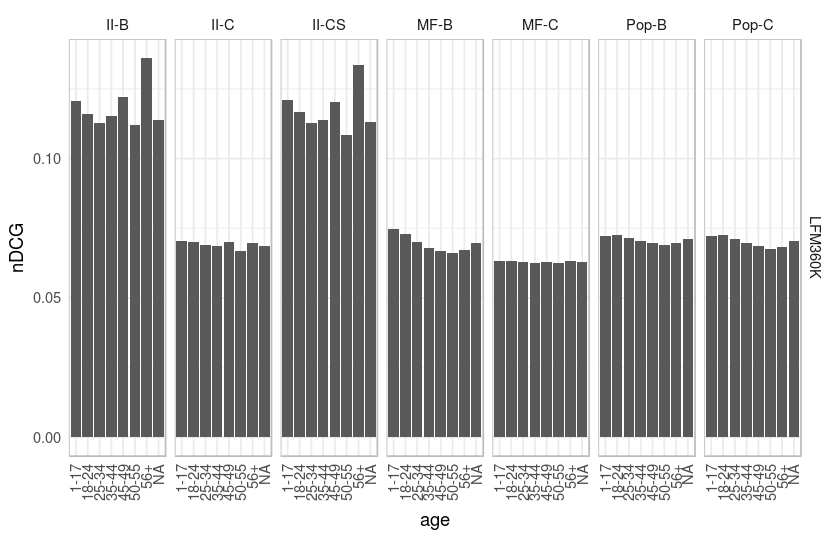

In [83]:
make.plot("u1r-age-ndcg-lfm", width=9, height=2, {
    ggplot(age.results %>% filter(DataSet == "LFM360K", !startsWith(Algorithm, "UU-"))) +
        aes(x=age, y=nDCG) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        theme_paper() +
        theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
})

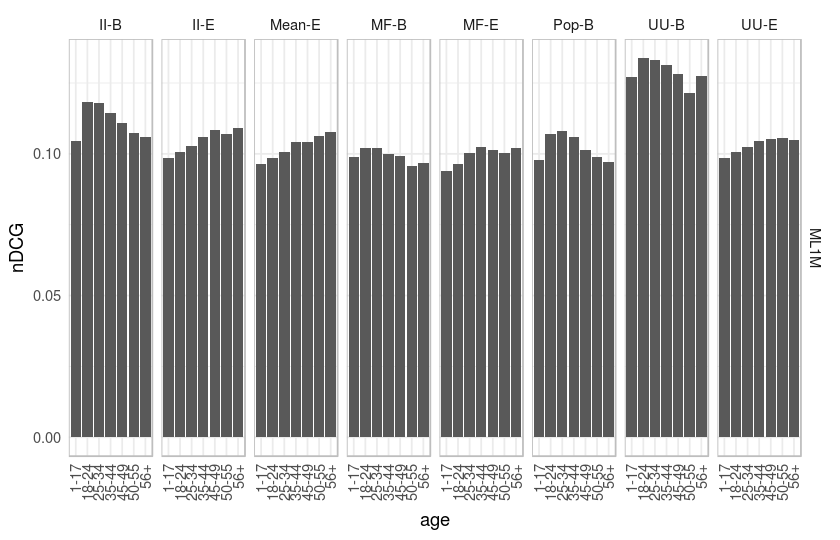

In [82]:
make.plot("u1r-age-ndcg-ml", width=9, height=2, {
    ggplot(age.results %>% filter(DataSet == "ML1M")) +
        aes(x=age, y=nDCG) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        theme_paper() +
        theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
})